In [1]:
# import libraries
from gettext import npgettext
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np
from statistics import mean, stdev

import json

In [2]:
# setup spark
spark = (
    SparkSession.builder.appName("aggregate data for first 3 final model variables")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "15g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/28 16:35:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/28 16:35:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/09/28 16:35:25 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
postcode_df = spark.read.csv("../data/curated/Grouping_bytotal.csv", header = "true")
persona_df = spark.read.csv("../data/curated/abs_cleaned.csv",  header = "true")

In [4]:
persona_df = persona_df.withColumnRenamed("_c0","postcode")

In [5]:
# mean age
cond = ["postcode"]
total_df = postcode_df.join(persona_df,cond, "left")

In [6]:
total_df

22/09/28 16:35:29 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/09/28 16:35:30 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , mean_Age, min_Age, q1_Age, median_Age, q3_Age, max_Age, Millen_Z%, Oceania and Antarctica, North-West Europe, Southern and Eastern Europe, North Africa and the Middle East, South-East Asia, North-East Asia, Southern and Central Asia, Americas, Sub-Saharan Africa, mean_Salary, median_Salary, min_Salary, q1_Salary, q3_Salary, max_Salary, Managers_%, Professionals_%, Technicians and Trades Workers_%, Community and Personal Service Workers_%, Clerical and Administrative Workers_%, Sales Workers_%, Machinery Operators and Drivers_%, Labourers_%, Total
 Schema: _c0, mean_Age, min_Age, q1_Age, median_Age, q3_Age, max_Age, Millen_Z%, Oceania and Antarctica, North-West Europe, Southern and Eastern Europe, North Africa and th

postcode,merchant_abn,count_postcode_merchant,total_order_per_fornight,proportion_of_postcode,mean_Age,min_Age,q1_Age,median_Age,q3_Age,max_Age,Millen_Z%,Oceania and Antarctica,North-West Europe,Southern and Eastern Europe,North Africa and the Middle East,South-East Asia,North-East Asia,Southern and Central Asia,Americas,Sub-Saharan Africa,mean_Salary,median_Salary,min_Salary,q1_Salary,q3_Salary,max_Salary,Managers_%,Professionals_%,Technicians and Trades Workers_%,Community and Personal Service Workers_%,Clerical and Administrative Workers_%,Sales Workers_%,Machinery Operators and Drivers_%,Labourers_%,Total
832,48214071373,1,385,0.002597402597402...,33.455230125523016,0,13,28,41,88,0.4120373350498874,0.7963910398230089,0.04466261061946902,0.008573008849557522,0.004079092920353983,0.0703816371681416,0.008227323008849558,0.036366150442477874,0.0078125,0.02350663716814159,835.47,1125.0,75.0,575.0,1625.0,2500.0,0.0538179949906878,0.0753965705478132,0.1023055680431571,0.0834243144306724,0.0915805022156573,0.0430287072121251,0.036478068203712,0.0443773681844454,15571
2210,24406529929,4,3000,0.001333333333333...,46.320220864508116,0,21,41,60,101,0.2833012056065606,0.6406750473566385,0.027415188565524367,0.05279834682280007,0.04325813673153091,0.05266058205613914,0.13952126743585327,0.02297227484070949,0.014809712416049595,0.005889443774754606,617.84,575.0,0.0,225.0,1125.0,1875.0,0.0513373880060166,0.0951867111372702,0.0559479432345824,0.042672160094173,0.0698450068667843,0.0428356549604342,0.0273036426656202,0.0350532993264011,30582
4022,38700038932,4,5117,0.000781708032050...,47.072724734785034,0,19,41,64,104,0.269821328866555,0.8544313256613362,0.07995815274248991,0.009565087430877297,0.002241817366611867,0.015244358092960694,0.005529816170975938,0.012554177253026454,0.007771633537587804,0.01270363174413391,513.51,575.0,75.0,350.0,900.0,1375.0,0.0340496790399106,0.0530281886687133,0.0574937203460787,0.053586380128384,0.0534468322634663,0.0450739603684063,0.0315378174713926,0.0442366731789003,7166
2128,38700038932,2,5117,0.000390854016025...,38.62224880382775,0,24,33,43,88,0.4667464114832536,0.60030824556897,0.014641664526072438,0.02337528898022091,0.059594143334189574,0.06062162856408939,0.14307731826354997,0.0611353711790393,0.017467248908296942,0.01977909067557154,338.61,725.0,0.0,225.0,1125.0,1625.0,0.0321651464234277,0.0513682189150264,0.042006721075372,0.0237638022083533,0.0446471435429668,0.0211233797407585,0.0208833413346135,0.0206433029284685,4166
6126,83412691377,4,10241,0.000390586856752...,47.67817896389325,0,32,43,54,83,0.2621664050235479,0.8003472222222222,0.1267361111111111,0.008680555555555556,0.0,0.026041666666666668,0.005208333333333333,0.012152777777777778,0.008680555555555556,0.012152777777777778,280.83,450.0,0.0,75.0,1125.0,1625.0,0.0530546623794212,0.0257234726688102,0.0434083601286173,0.0273311897106109,0.0144694533762057,0.0144694533762057,0.0080385852090032,0.0209003215434083,622
6616,38700038932,1,5117,0.000195427008012...,54.96,10,47,49,67,67,0.0,0.9285714285714286,0.07142857142857142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,361.84,725.0,0.0,75.0,900.0,1375.0,0.2105263157894736,0.0,0.0,0.0,0.0526315789473684,0.0,0.0526315789473684,0.0526315789473684,57
834,73841664453,2,692,0.002890173410404624,42.28376906318083,0,18,40,54,83,0.27832244008714596,0.8910336239103362,0.057285180572851806,0.0136986301369863,0.0,0.021793275217932753,0.003735990037359...,0.00311332503113325,0.002490660024906...,0.00684931506849315,871.76,1125.0,75.0,575.0,1625.0,2500.0,0.0806979280261723,0.074700109051254,0.1172300981461286,0.0501635768811341,0.084514721919302,0.0430752453653217,0.039803707742639,0.0408942202835332,1834
3046,83412691377,2,10241,0.000195293428376...,43.13015686849435,0,21,35,54,101,0.3557836094414309,0.5936944373888747,0.02489204978409957,0.09337693675387351,0.07947040894081789,0.035941071882143766,0.023241046482092964,0.1332232664465329,0.008826517653035305,0.007334264668529337,560.8,575.0,0.0,350.0,1125.0,1625.0,0.0418367

In [7]:
listofmult = total_df.columns[6:]
listofmult

['min_Age',
 'q1_Age',
 'median_Age',
 'q3_Age',
 'max_Age',
 'Millen_Z%',
 'Oceania and Antarctica',
 'North-West Europe',
 'Southern and Eastern Europe',
 'North Africa and the Middle East',
 'South-East Asia',
 'North-East Asia',
 'Southern and Central Asia',
 'Americas',
 'Sub-Saharan Africa',
 'mean_Salary',
 'median_Salary',
 'min_Salary',
 'q1_Salary',
 'q3_Salary',
 'max_Salary',
 'Managers_%',
 'Professionals_%',
 'Technicians and Trades Workers_%',
 'Community and Personal Service Workers_%',
 'Clerical and Administrative Workers_%',
 'Sales Workers_%',
 'Machinery Operators and Drivers_%',
 'Labourers_%',
 'Total']

In [8]:
total_df = total_df.withColumn("arr", F.struct(*[(F.col(x)*F.col('proportion_of_postcode')).alias(x) for x in listofmult]))\
  .select("postcode","merchant_abn","count_postcode_merchant","total_order_per_fornight","arr.*")

In [9]:
exprs = {x: "sum" for x in listofmult}
final_df1 = total_df.groupBy("merchant_abn").agg(exprs)

In [10]:
final_df1.toPandas().to_csv('../data/curated/Postcode_Persona_bytotal.csv', index = False)

22/09/28 16:35:31 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , min_Age, q1_Age, median_Age, q3_Age, max_Age, Millen_Z%, Oceania and Antarctica, North-West Europe, Southern and Eastern Europe, North Africa and the Middle East, South-East Asia, North-East Asia, Southern and Central Asia, Americas, Sub-Saharan Africa, mean_Salary, median_Salary, min_Salary, q1_Salary, q3_Salary, max_Salary, Managers_%, Professionals_%, Technicians and Trades Workers_%, Community and Personal Service Workers_%, Clerical and Administrative Workers_%, Sales Workers_%, Machinery Operators and Drivers_%, Labourers_%, Total
 Schema: _c0, min_Age, q1_Age, median_Age, q3_Age, max_Age, Millen_Z%, Oceania and Antarctica, North-West Europe, Southern and Eastern Europe, North Africa and the Middle East, South-East Asia, North-East Asia, Southern and Central Asia, Americas, Sub-Saharan Africa, mean_Salary, median_Salary, min_Salary, q1_Salary, q3_Salary, max_Salary, Managers_%, Professi

In [11]:
final_df1

22/09/28 16:35:35 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , min_Age, q1_Age, median_Age, q3_Age, max_Age, Millen_Z%, Oceania and Antarctica, North-West Europe, Southern and Eastern Europe, North Africa and the Middle East, South-East Asia, North-East Asia, Southern and Central Asia, Americas, Sub-Saharan Africa, mean_Salary, median_Salary, min_Salary, q1_Salary, q3_Salary, max_Salary, Managers_%, Professionals_%, Technicians and Trades Workers_%, Community and Personal Service Workers_%, Clerical and Administrative Workers_%, Sales Workers_%, Machinery Operators and Drivers_%, Labourers_%, Total
 Schema: _c0, min_Age, q1_Age, median_Age, q3_Age, max_Age, Millen_Z%, Oceania and Antarctica, North-West Europe, Southern and Eastern Europe, North Africa and the Middle East, South-East Asia, North-East Asia, Southern and Central Asia, Americas, Sub-Saharan Africa, mean_Salary, median_Salary, min_Salary, q1_Salary, q3_Salary, max_Salary, Managers_%, Professi

22/09/28 16:35:39 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , min_Age, q1_Age, median_Age, q3_Age, max_Age, Millen_Z%, Oceania and Antarctica, North-West Europe, Southern and Eastern Europe, North Africa and the Middle East, South-East Asia, North-East Asia, Southern and Central Asia, Americas, Sub-Saharan Africa, mean_Salary, median_Salary, min_Salary, q1_Salary, q3_Salary, max_Salary, Managers_%, Professionals_%, Technicians and Trades Workers_%, Community and Personal Service Workers_%, Clerical and Administrative Workers_%, Sales Workers_%, Machinery Operators and Drivers_%, Labourers_%, Total
 Schema: _c0, min_Age, q1_Age, median_Age, q3_Age, max_Age, Millen_Z%, Oceania and Antarctica, North-West Europe, Southern and Eastern Europe, North Africa and the Middle East, South-East Asia, North-East Asia, Southern and Central Asia, Americas, Sub-Saharan Africa, mean_Salary, median_Salary, min_Salary, q1_Salary, q3_Salary, max_Salary, Managers_%, Professi

merchant_abn,sum(Professionals_%),sum(median_Age),sum(q1_Salary),sum(Machinery Operators and Drivers_%),sum(Southern and Central Asia),sum(max_Age),sum(min_Salary),sum(Oceania and Antarctica),sum(North-East Asia),sum(Sales Workers_%),sum(mean_Salary),sum(Sub-Saharan Africa),sum(Technicians and Trades Workers_%),sum(Community and Personal Service Workers_%),sum(North Africa and the Middle East),sum(q3_Age),sum(Total),sum(North-West Europe),sum(max_Salary),sum(q1_Age),sum(Labourers_%),sum(Southern and Eastern Europe),sum(min_Age),sum(Managers_%),sum(South-East Asia),sum(Americas),sum(median_Salary),sum(q3_Salary),sum(Clerical and Administrative Workers_%),sum(Millen_Z%)
33026294208,0.07771683404005617,41.95275590551181,344.68503937007864,0.03293389158429409,0.022449597575445974,91.18897637795277,96.49606299212599,0.8356075234793297,0.01832530498670294,0.03476036852603081,601.7345669291338,0.009980993274511813,0.05842779371092192,0.045728917751423494,0.007631613361027872,57.44094488188976,8182.165354330708,0.06165932621490788,1786.8110236220473,22.385826771653544,0.053516437385505565,0.01676030540405487,1.047244094488189,0.09470281331138154,0.020281125683191552,0.007304210020827441,641.5354330708661,1127.0177165354332,0.051658306175388385,0.2732815830230819
37629693091,0.07962544788986245,42.87692307692308,358.7307692307694,0.030280832338131464,0.01785439949377276,91.5446153846154,98.45384615384614,0.8328893564040003,0.020381060467848298,0.03291953858065256,614.0491692307692,0.008812867752912394,0.059377806002428014,0.04464323791376679,0.00753921517644526,58.661538461538456,7640.310769230769,0.06296429510575839,1841.676923076923,22.17538461538462,0.0521963412481352,0.018967745333463865,0.84,0.08926480266768351,0.022418088453027757,0.008172971812771043,673.0384615384617,1175.0192307692307,0.04871406881807884,0.2629323592249107
60963420870,0.0793663979869821,42.31578947368421,331.688596491228,0.036555976607685836,0.015982430684453323,92.99999999999999,71.84210526315789,0.8457599860917483,0.015853430579327116,0.03153001666948066,599.1659649122807,0.008746915204924717,0.059382752193253154,0.0442763368931459,0.008635657968709326,58.47368421052631,10153.491228070176,0.05687865135987904,1796.315789473684,21.596491228070175,0.053200978567184504,0.01996975080842057,0.38596491228070173,0.08455137898345992,0.019704933235887078,0.008468244066650449,639.4736842105264,1155.9210526315787,0.051761148147871486,0.26490622814511045
11633090957,0.07945375245234074,41.68879668049792,344.63174273858914,0.0314904475745397,0.01899695494794962,91.83817427385895,83.44398340248961,0.8313442107948786,0.017706561258981613,0.03423547131985317,614.0092116182573,0.00914729798923945,0.060396823489265374,0.045001360862664694,0.007748517248954...,58.05809128630706,8823.680497925312,0.06377319998552665,1812.1161825726147,21.219917012448136,0.05035400863127038,0.019204324736714157,0.6224066390041494,0.08592222005182754,0.023822509693693195,0.008256423344062352,655.3941908713693,1160.191908713693,0.051870624244288475,0.2687167252218074
86137100428,0.09066782634609047,40.68421052631579,348.68421052631584,0.03230181203683996,0.013074290786689313,91.78947368421052,59.210526315789465,0.8208594809751864,0.024113558434150716,0.031988840144233366,667.0131578947369,0.010287200209773936,0.04822978452486314,0.0427314935773314,0.005891888975565331,57.10526315789474,9882.21052631579,0.0594467107419897,2085.5263157894738,23.157894736842106,0.047651404310172625,0.014259773019305075,0.7894736842105263,0.10507120641554582,0.0419034227186825,0.010163674138657059,734.2105263157895,1269.4078947368419,0.05133674662917849,0.2937765243333466
36866208934,0.07959645558102324,41.78277634961439,353.2696015424164,0.030692593525478526,0.01648523069057341,90.54113110539845,89.73329048843185,0.8293254322175526,0.019537180674187006,0.03388171134681327,615.4347557840616,0.009373296626560283,0.05876417836611033,0.04517708383361886,0.008173105166372987,57.431876606683794,9200.515424164525,0.063975662

In [12]:
final_df1.describe()

22/09/28 16:35:41 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , min_Age, q1_Age, median_Age, q3_Age, max_Age, Millen_Z%, Oceania and Antarctica, North-West Europe, Southern and Eastern Europe, North Africa and the Middle East, South-East Asia, North-East Asia, Southern and Central Asia, Americas, Sub-Saharan Africa, mean_Salary, median_Salary, min_Salary, q1_Salary, q3_Salary, max_Salary, Managers_%, Professionals_%, Technicians and Trades Workers_%, Community and Personal Service Workers_%, Clerical and Administrative Workers_%, Sales Workers_%, Machinery Operators and Drivers_%, Labourers_%, Total
 Schema: _c0, min_Age, q1_Age, median_Age, q3_Age, max_Age, Millen_Z%, Oceania and Antarctica, North-West Europe, Southern and Eastern Europe, North Africa and the Middle East, South-East Asia, North-East Asia, Southern and Central Asia, Americas, Sub-Saharan Africa, mean_Salary, median_Salary, min_Salary, q1_Salary, q3_Salary, max_Salary, Managers_%, Professi

summary,merchant_abn,sum(Professionals_%),sum(median_Age),sum(q1_Salary),sum(Machinery Operators and Drivers_%),sum(Southern and Central Asia),sum(max_Age),sum(min_Salary),sum(Oceania and Antarctica),sum(North-East Asia),sum(Sales Workers_%),sum(mean_Salary),sum(Sub-Saharan Africa),sum(Technicians and Trades Workers_%),sum(Community and Personal Service Workers_%),sum(North Africa and the Middle East),sum(q3_Age),sum(Total),sum(North-West Europe),sum(max_Salary),sum(q1_Age),sum(Labourers_%),sum(Southern and Eastern Europe),sum(min_Age),sum(Managers_%),sum(South-East Asia),sum(Americas),sum(median_Salary),sum(q3_Salary),sum(Clerical and Administrative Workers_%),sum(Millen_Z%)
count,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417
mean,5.468708991950147E10,0.07744443156071196,41.70565633493559,350.55482237177984,0.03168843755900313,0.01598929918460963,90.46523112770956,88.79570493829078,0.8330184365369127,0.018461685996379734,0.03357710777098126,614.2566192661698,0.009156159272041013,0.05879601905305955,0.04453354730315992,0.007372103466401633,57.43976662671826,8757.131310812634,0.0627539563455894,1833.6667837031882,21.47067119737623,0.052303727940316035,0.01847820638470763,1.0528476344682483,0.09086120652670589,0.02199545027345355,0.008274254852446202,662.5349214891717,1176.6289992663362,0.0506470233918444,0.26713672653302367
stddev,2.5951720879185E10,0.009438668250825219,1.6088598574949518,23.062990375327743,0.004114432005973005,0.005227266180207604,2.4277884849919267,20.358199432785366,0.02754760605534492,0.009773230773427087,0.002646698708739...,31.36103325691763,0.002006290878856679,0.004585124139612476,0.012383459545829043,0.003917539773210979,1.6575103181433097,2190.359511590151,0.007181707170337678,105.22115286825724,1.3917752368322098,0.006050535375455521,0.004223421001947613,1.348766664317352,0.01136230430438698,0.006901117014613921,0.001868398486094...,38.858677790094426,67.27676370329137,0.003768125737999336,0.02359827726339573
min,10023283211,0.0,17.0,0.0,0.0,0.0,40.5,0.0,0.1804342624715875,0.0,0.0,304.015,0.0,0.0,0.0,0.0,23.0,22.0,0.0,925.0,9.0,0.0,0.0,0.0,0.0106082036775106,0.0,0.0,225.0,575.0,0.0,0.0
max,99990536339,0.2068155841432744,69.0,725.0,0.1008827238335435,0.11129292223774548,103.0,725.0,1.0,0.394185907405192,0.0527418473310256,1027.52,0.04912110322912575,0.09690766550522639,0.8333333333333334,0.19548353732115153,69.0,42552.0,0.14038565951108462,3500.0,69.0,0.1818181818181818,0.09346279395424348,69.0,0.2603682331975303,0.23226462495513817,0.03876061729871994,1100.0,1916.6666666666665,0.1052631578947368,0.9527027027027027


In [15]:
import matplotlib.pyplot as plt

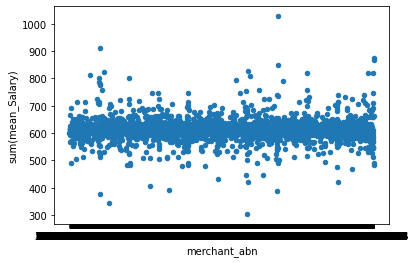

In [26]:
pandas_df = final_df1.toPandas()
scatter = pandas_df.plot.scatter(y='sum(mean_Salary)',x='merchant_abn')

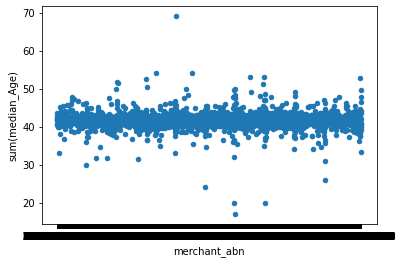

In [27]:
scatter1 = pandas_df.plot.scatter(y='sum(median_Age)',x='merchant_abn')

In [ ]:
histo = pandas_df.hist('sum(mean_Salary)')